**Conclusion**
We have to swap the sign of the imaginary part because otherwise the time evolution goes back it time

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import numpy as np
import os
import sys; sys.path.insert(1, './classes/')
import matplotlib.pyplot as plt; plt.style.use('ggplot')

from elastostatic import *
from tools import *

--> Server: 'https://l.mondaic.com/licensing_server', User: 'andrei.dmitrovskii', Group: 'ETHZ_ERDW_SEG'.
--> Negotiating 1 license instance(s) for 'SalvusMesh' [license version 1.0.0] for 1 seconds ...
--> Success! [Total duration: 0.34 seconds]


In [4]:
def open_simple_grid(filename = '../stations/LandOceanGrid_x_2.0_y_2.0_bounds_-89_89_0_360.txt'):
    with open(filename, 'r') as file:
        return np.array([line.split() for line in file.readlines()], dtype=float)
    
def polar2compl(magn, phase):
    r = magn*np.cos(phase)
    i = magn*np.sin(phase)
    return r, i

def compl2polar(real, imag):
    absv  = np.linalg.norm([real, imag])
    phase = np.arctan2(imag, real)
    phase = phase if imag > 0 else 2*np.pi + phase
    return absv, phase

In [5]:
regular_grid = open_simple_grid()

In [6]:
a = elastostatic_solver(meshfile = "../meshes/elastostatic/mesh.h5")
a.config.run.tensor_order = 2
a.construct_mesh(with_surface_topo = False, 
                 with_moho_topo = False, 
                 oneD_model="prem_iso_one_crust",
                 nex = 15, 
                 buffer = 0, 
                 local_refinement_level=0, 
                 global_refinement_level=0)


./classes/octiload_class.py:95: UserWarning: min_z below CMB, including fluid with mu=0 as elastic
  self.mesh = ms.create_mesh(verbose=True)


number of elements:  12425
amp 0.14937283 0.1910651
re 7.761588e-05 0.16453516
im -2.6916323e-05 0.17817493
sea_mask_grad 2.0402913 7.001373
attaching elastic parameters

SUCCESSFULLY GENERATED MESH IN 4.04321 SECONDS.


In [21]:
sph_crd = get_sph_coord(a.mesh)
mask = (sph_crd[:,:,2] > 6370e3)
real = a.mesh.elemental_fields['tidal_elevation_re'][mask]
imag = a.mesh.elemental_fields['tidal_elevation_im'][mask] * (-1)

compl = np.zeros_like(real, dtype=complex)
compl.real, compl.imag = real, imag

absl = np.absolute(compl)
phase = np.angle(compl)
latitude = sph_crd[:,:,0][mask]
longitude = sph_crd[:,:,1][mask]

/home/admitrov/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/admitrov/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  


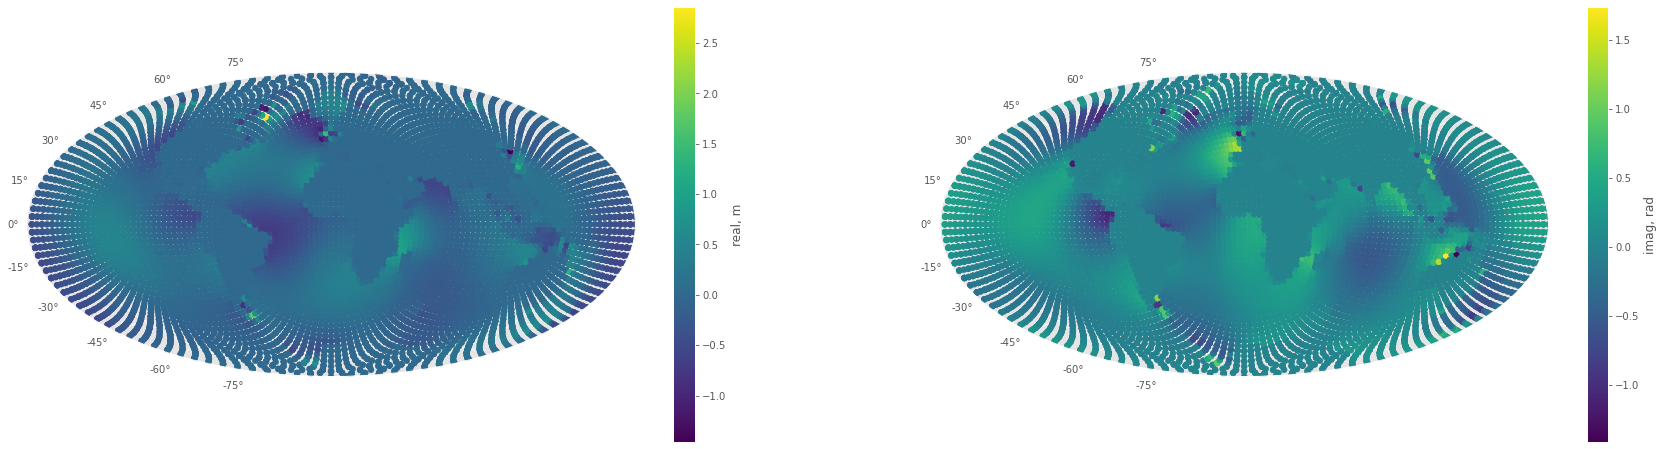

In [22]:
fig, ax = plt.subplots(1,2,figsize=(30,8), subplot_kw={"projection":'aitoff'})
im = ax[0].scatter(longitude, latitude, c=real, label='real')
plt.colorbar(im, ax=ax[0], label=f'real, m')

im = ax[1].scatter(longitude, latitude, c=imag, label='imag')
plt.colorbar(im, ax=ax[1], label=f'imag, rad')

/home/admitrov/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/admitrov/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  


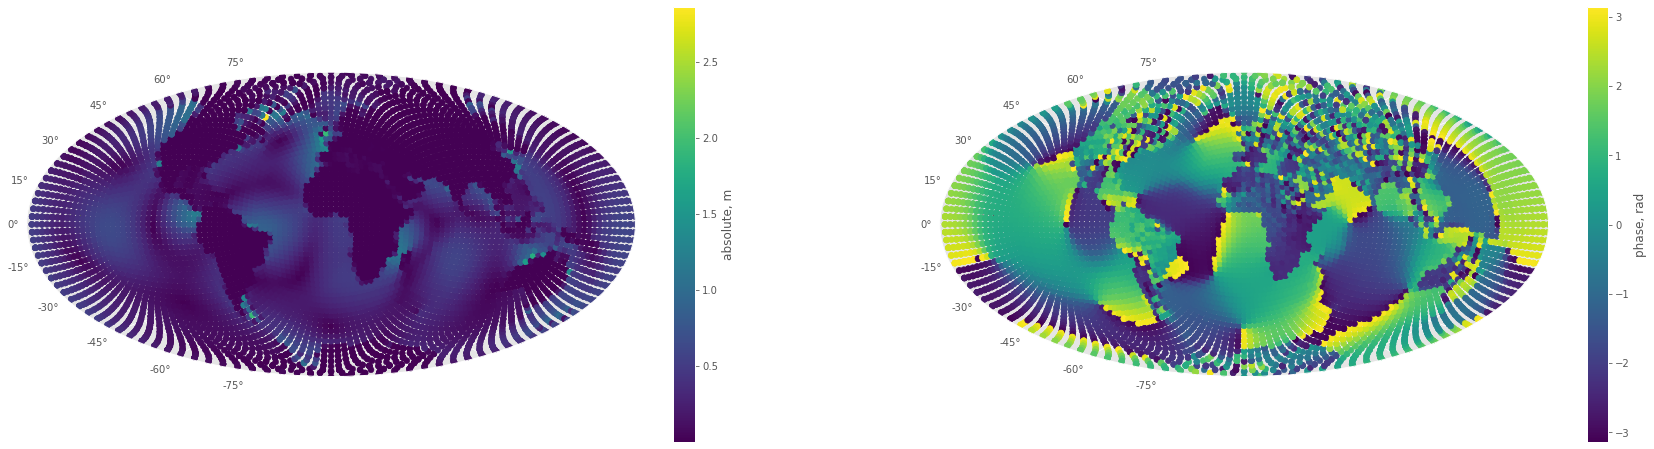

In [23]:
fig, ax = plt.subplots(1,2,figsize=(30,8), subplot_kw={"projection":'aitoff'})
im = ax[0].scatter(longitude, latitude, c=absl, label='absolute')
plt.colorbar(im, ax=ax[0], label=f'absolute, m')

im = ax[1].scatter(longitude, latitude, c=phase, label='phase')
plt.colorbar(im, ax=ax[1], label=f'phase, rad')

In [24]:
T_M2 = 12.42*3600.
omega_M2 = 2 * np.pi / T_M2
def load_at_time(t, A, Phi, omega ):
    return A * np.cos(omega*t - Phi)

In [25]:
N = 40
times = np.linspace(0., 2*T_M2, N)
timeshots = np.zeros((N, len(absl)))
for i, t in enumerate(times):
    timeshots[i] = load_at_time(t = t, A = absl, Phi=phase, omega = omega_M2)

In [26]:
for i in range(N):
    fig, ax = plt.subplots(figsize=(10,8), subplot_kw={"projection":'aitoff'})
    im = ax.scatter(longitude, latitude, c=timeshots[i])
    plt.savefig(f'./pic/t_{times[i]}.png')
    plt.close()
#fig.colorbar(im, ax=ax, label=f't={times[i]} sec: tide height, m')